# Plotting Data from NCEI's Climate at a Glance Tool
## Written By Jared Rennie

This tutorial uses python to download and plot data from <a href='https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/national' target="_blank">NCEI's Climate at a Glance</a> Tool. Specifically, it plots a map for each US state (and also provides a SHP/KML file of the results).

### What You Need

First off, the entire codebase works in Python... sort of. 

You will need the following programs installed: 
- Python
- numpy | pandas | geopandas | shapely | matplotlib | cartopy | simplekml 
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com/' target="_blank">Anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import Packages
%matplotlib inline
import sys, time, datetime, os, requests
import numpy as np
import geopandas as gpd
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import simplekml
from shapely.geometry import Polygon, MultiPolygon
import shapely.geometry as sgeom

print("SUCCESS")

SUCCESS


### Choose a month and element

If you made it this far, great! Now we need to know what to plot. You need to in put some info, including:

- Year/Month
- Element (tmax/tmin/tavg/prcp)
- Whether you want current month, or the "year-to-date" data (January up to month selected)
- Who is plotting the data

In [2]:
#Insert Arguments Here
inYear= '2024'
inMonth= '8'
inElement= 'tmin' #tmax/tmin/tavg/pcp
inTime='ytd' # 1month/ytd
author='Not Jared Rennie'

This block of code will Set Up some variables, based upon your inputs. This will help us get the data we need, and plot later. In theory you do not have to change this block of code.

In [3]:
if inElement.lower() == 'tavg':
    outElement='Average Temperature'
if inElement.lower() == 'tmax':
    outElement='Maximum Temperature'
if inElement.lower() == 'tmin':
    outElement='Minimum Temperature'
if inElement.lower() == 'pcp':
    outElement='Precipitation'

if inElement.lower() == 'pcp':
    rank_hexs=['#8c510a', '#d8b365', '#f6e8c3', '#f5f5f5', '#c7eae5', '#5ab4ac', '#01665e']
    hex_labels = ['Driest','Bottom 10','Bottom Third','Normal','Top Third','Top 10','Wettest']
else:
    rank_hexs=['#2166ac', '#67a9cf', '#d1e5f0', '#f7f7f7', '#fddbc7', '#ef8a62', '#b2182b']
    hex_labels=['Coldest', 'Bottom 10', 'Bottom Third', 'Normal', 'Top Third', 'Top 10', 'Warmest']

# Define inputs based on input arguments
months=np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],dtype=str)
input_month="%04i%02i" % (int(inYear),int(inMonth))
if inTime == '1month':
    outDate=str(months[int(inMonth)-1])
    fileCode=1
if inTime == 'ytd':
    outDate="Jan-"+str(months[int(inMonth)-1])
    fileCode=str(int(inMonth))
outTitle1=outElement+" Ranks: "+str(outDate)+" "+str(inYear)
print(outTitle1)

Minimum Temperature Ranks: Jan-Aug 2024


### Download Data
This block of code will download the data we need from the NCEI Website.

In [4]:
fmtYear= "%04i" % (int(inYear))
fmtonth= "%02i" % (int(inMonth))
fmtDate=fmtYear+fmtonth
fmtFile='110-'+inElement.lower()+'-'+str(fmtDate)+'-'+str(fileCode)+'.csv'

# URL of the file
url = 'https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/mapping/'+fmtFile
print(url)

# Send a GET request to the URL
response = requests.get(url)

# Save the content to a local file
with open(fmtFile, 'wb') as file:
    file.write(response.content)
    
print("SUCCESSFULLY GOT FILE FROM NCEI: ",fmtFile)

https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/mapping/110-tmin-202408-8.csv
SUCCESSFULLY GOT FILE FROM NCEI:  110-tmin-202408-8.csv


### Ok let's read some data.

This block of code will read in the data, and do some cleaning, because getting the data is half the battle.

First, we have to figure out which category the rank is in (highest, top ten, top third, etc). The other fun thing is that because we are only looking at the lower 48 states, the state codes NCEI uses differs from what the census bureau uses (fun!). So we have to account for that. This block of code does this stuff.

In [5]:
# Define NCEI inputs that will change each year and category
numYears=130 # 1895-2024
highest_thresh=numYears
top_ten_thresh=121 # 121-130 is top 10 in 2024
top_third_thresh=87
bottom_third_thresh=43
bottom_ten_thresh=10
lowest_thresh=1

#################################################
# READ IN CSV File (NCEI)
input_csv=fmtFile
print("READING IN NCEI DATA: ",input_csv)
data_ncei = pd.read_csv(input_csv,sep=',',skiprows=4)

# Need State Reference file
state_ref=pd.read_csv('stateFIPS.csv',usecols=["state_name","actual_state_fips"]).astype(str)
state_ref=state_ref.set_index('state_name')['actual_state_fips'].to_dict()

# Add FIPS Column, then run through each row
data_ncei['FIPS']=np.full(data_ncei.shape[0],"N/A").astype(str) 
data_ncei['HEX']=np.full(data_ncei.shape[0],"N/A").astype(str) 
for index, row in data_ncei.iterrows():
    # Figure out FIPS
    stateCode=row['ID']
    stateFIPS= "%02i" % (int(state_ref[str(row['Name'])]))
    actualFIPS=stateFIPS
    data_ncei.at[index, 'FIPS'] = actualFIPS

    # Figure out Hex 
    val=row['Rank']
    if val==highest_thresh:
        outColor=rank_hexs[6]
    elif val>=top_ten_thresh and val <=highest_thresh-1:
        outColor=rank_hexs[5]
    elif val>=top_third_thresh and val <=top_ten_thresh-1:
        outColor=rank_hexs[4]
    elif val >=bottom_third_thresh+1 and val <= top_third_thresh-1:
        outColor=rank_hexs[3]
    elif val >= bottom_ten_thresh+1 and val<=bottom_third_thresh:
        outColor=rank_hexs[2]
    elif val >=lowest_thresh+1 and val<=bottom_ten_thresh:
        outColor=rank_hexs[1]
    elif val==lowest_thresh:
        outColor=rank_hexs[0]
    else:
        outColor='gray'
    data_ncei.at[index, 'HEX'] = outColor

# Only Get Cols of Interest 
data_ncei=pd.DataFrame({'FIPS':data_ncei['FIPS'],'NCEI_RANK':data_ncei['Rank'],'HEX':data_ncei['HEX']}) 

# Add new row and Sort Before Join
data_ncei['GEOID2_INT']=data_ncei['FIPS'].astype(int)
data_ncei=data_ncei.sort_values(by=['GEOID2_INT']) # Sort

print(data_ncei)

READING IN NCEI DATA:  110-tmin-202408-8.csv
   FIPS  NCEI_RANK      HEX  GEOID2_INT
0    01        122  #ef8a62           1
1    04        125  #ef8a62           4
2    05        127  #ef8a62           5
3    06        126  #ef8a62           6
4    08        119  #fddbc7           8
5    09        130  #b2182b           9
6    10        127  #ef8a62          10
7    12        125  #ef8a62          12
8    13        124  #ef8a62          13
9    16        120  #fddbc7          16
10   17        127  #ef8a62          17
11   18        127  #ef8a62          18
12   19        125  #ef8a62          19
13   20        121  #ef8a62          20
14   21        127  #ef8a62          21
15   22        124  #ef8a62          22
16   23        129  #ef8a62          23
17   24        130  #b2182b          24
18   25        130  #b2182b          25
19   26        130  #b2182b          26
20   27        127  #ef8a62          27
21   28        126  #ef8a62          28
22   29        127  #ef8a62        

### Joining with State Shapefile
In order for appropriate plotting, we need to join the data by a state shapefile. It is provided in this notebook. For simplicity, we are going to remove states in the shapefile that we are NOT joining (sorry Alaska, Hawaii, Puerto Rico, and occupying islands).

In [6]:
#################################################
# READ IN SHAPEFILE
input_shapefile='./input_shapefile/cb_2018_us_state_500k.shp'

print("READ IN SHAPEFILE: ",input_shapefile)
geo_shapefile = gpd.read_file(input_shapefile)
geo_shapefile['GEOID2_INT'] = np.array(geo_shapefile['GEOID'].values,dtype='i')

# Get Projection
projection=geo_shapefile.crs

# Do some cleaning
geo_shapefile.drop(geo_shapefile[geo_shapefile['GEOID2_INT'] == 2].index, inplace=True)
geo_shapefile.drop(geo_shapefile[geo_shapefile['GEOID2_INT'] == 15].index, inplace=True)
geo_shapefile.drop(geo_shapefile[geo_shapefile['GEOID2_INT'] == 11].index, inplace=True)
geo_shapefile.drop(geo_shapefile[geo_shapefile['GEOID2_INT'] > 56].index, inplace=True)
geo_shapefile=geo_shapefile.sort_values(by='GEOID2_INT').reset_index()

print("SUCCESS")

READ IN SHAPEFILE:  ./input_shapefile/cb_2018_us_state_500k.shp
SUCCESS


Now we can perform the join (combining the NCEI Ranks with the state shapefile)

In [7]:
#################################################
# Join
print("\nJOIN")

# Perform the Join
out_shapefile=geo_shapefile.merge(data_ncei, on='GEOID2_INT', how='left')

print(out_shapefile)


JOIN
    index STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      17      01  01779775  0400000US01    01     AL         Alabama   00   
1      35      04  01779777  0400000US04    04     AZ         Arizona   00   
2      52      05  00068085  0400000US05    05     AR        Arkansas   00   
3      16      06  01779778  0400000US06    06     CA      California   00   
4      21      08  01779779  0400000US08    08     CO        Colorado   00   
5      55      09  01779780  0400000US09    09     CT     Connecticut   00   
6      43      10  01779781  0400000US10    10     DE        Delaware   00   
7       9      12  00294478  0400000US12    12     FL         Florida   00   
8      18      13  01705317  0400000US13    13     GA         Georgia   00   
9       8      16  01779783  0400000US16    16     ID           Idaho   00   
10     29      17  01779784  0400000US17    17     IL        Illinois   00   
11     53      18  00448508  0400000US18    18     IN     

### Save as SHP
Let's save as SHP so it can be used in products like ESRI

In [8]:
#################################################
# Save as new shapefile
print("\nSAVE AS SHP")
finalShp='./'+input_csv+'.shp'
print("OUTPUT TO: "+str(finalShp))
out_shapefile.to_file(finalShp)
print("SUCCESS!")


SAVE AS SHP
OUTPUT TO: ./110-tmin-202408-8.csv.shp
SUCCESS!


### Save as KML
Let's save as KML so it can be used in products like Google Earth

In [9]:
#################################################
# Save as KML
print("\nSAVE AS KML")
finalKml='./'+input_csv+'.kml'

# Assuming your geopandas DataFrame is named 'gdf'
# Adjust this to the variable where your DataFrame is stored
gdf = out_shapefile

# Initialize KML object
kml = simplekml.Kml()

# Iterate through each row in the geopandas DataFrame
for idx, row in gdf.iterrows():
    # Handle single Polygon case
    if isinstance(row.geometry, Polygon):
        coords = list(row.geometry.exterior.coords)
        pol = kml.newpolygon(name=row['STATEFP'], outerboundaryis=coords)
        
    # Handle MultiPolygon case by iterating over its .geoms
    elif isinstance(row.geometry, MultiPolygon):
        for poly in row.geometry.geoms:
            coords = list(poly.exterior.coords)
            pol = kml.newpolygon(name=row['STATEFP'], outerboundaryis=coords)
    
    # Assign hex color in KML format (aabgrrggbb where aa is transparency)
    hex_color = row['HEX'].lstrip('#')
    kml_color = f"ff{hex_color[4:]}{hex_color[2:4]}{hex_color[:2]}"  # Convert to KML format

    # Set polygon style: color and outline
    pol.style.polystyle.color = kml_color
    pol.style.polystyle.fill = 1  # Filled polygon
    pol.style.linestyle.width = 0  # No border line

# Save the KML file
kml.save(finalKml)
print("SUCCESS")


SAVE AS KML
SUCCESS


tNow for the fun part...

### Plotting the data!

PLOTTING (RANK)


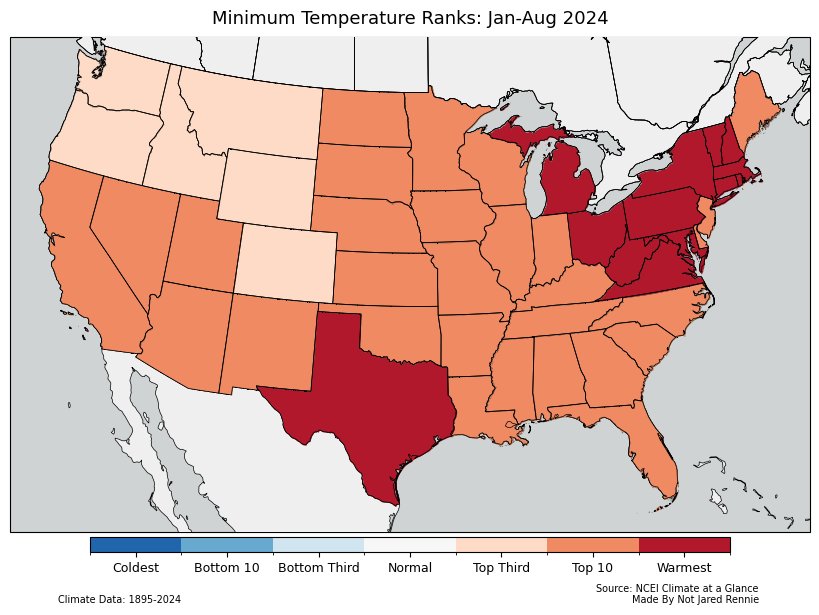

In [10]:
#################################################
# PLOTTING ('RANK')
print("PLOTTING (RANK)")

# Define Some Plotting Stuff
minLat = 22
maxLat = 50
minLon = -120
maxLon = -73

land_hex='#efefef'  # ESRI Light Gray Canvas
ocean_hex='#cfd3d4' # ESRI Light Gray Canvas
dpi=100
inCode='NCEI_RANK'
outValues=np.array(out_shapefile[inCode].values,dtype='i')

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_facecolor(ocean_hex)
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())

# Plot Data For Each County
attribute_counter=0
for county in shpreader.Reader(finalShp).geometries():
    val=out_shapefile.iloc[attribute_counter][inCode]
    stateFips=out_shapefile.iloc[attribute_counter]['FIPS']
    stateName=out_shapefile.iloc[attribute_counter]['NAME']
    outColor=out_shapefile.iloc[attribute_counter]['HEX']
    #print(stateFips,stateName,val,outColor)

    ax.add_geometries([county], ccrs.PlateCarree(),facecolor=outColor, edgecolor='black',linewidth=0.10,zorder=9)
    attribute_counter+=1
ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=6)
ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor='black',zorder=7)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor='black',zorder=8)
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='black',zorder=10)

# Add ColorMap 
cmap = mpl.colors.ListedColormap(rank_hexs)
bounds = np.arange(cmap.N+1) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='horizontal')

# Define tick locations and labels
labels = hex_labels
tick_locations = np.arange(0.5, float(len(labels)+0.5), 1)  # Adjust the number of tick locations to match the number of boundaries
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(labels)
cbar.ax.tick_params(labelsize=9)

# Add Titles
plt.suptitle(outTitle1,size=13,color='black',y=1.05) 
plt.annotate('Source: NCEI Climate at a Glance\nMade By '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,backgroundcolor='white',color='black',horizontalalignment='right', verticalalignment='bottom')
plt.annotate('Climate Data: 1895-2024',xy=(-0.05, -3.51), xycoords='axes fraction', fontsize=7,backgroundcolor='white',color='black',horizontalalignment='left', verticalalignment='bottom')

plt.show()

Isn't it beautiful?

**Congrats on completing this notebook! Now go forth and make better plots!**